# Gerry_William_Nanlohy_2440018854_LB01_COMP6587001 - Deep Learning_MID Number 2

2. Eudora memiliki kakak perempuan bernama Eurydice yang merupakan penderita tuna rungu. Dalam memahami apa yang dikatakan oleh Eurydice, Eudora harus mempelajari Sign Language. Kalian diminta untuk membuat sebuah aplikasi sederhana untuk membaca Sign Language yang dibuat oleh Eurydice. Saat pengembangan aplikasi pertama memiliki batasan hanya bekerja pada data alphabet. Data didapatkan dari https://bit.ly/UTSDeepLearning dengan filename bernama ASL.zip. Buatlah simple Convolutional Neural Network dengan 
beberapa ketentuan berikut:

***Import the required libraries***

In [1]:
import numpy as np
import pandas as pd
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as Func
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader

***Unzipping the dataset because the dataset is still in zip form***

In [27]:
import zipfile
from google.colab import drive 
drive.mount('/content/drive/')

Mounted at /content/drive/


In [29]:
!unzip /content/ASL.zip -d /content/drive/MyDrive/ColabNotebook

Streaming output truncated to the last 5000 lines.
  inflating: /content/drive/MyDrive/ColabNotebook/ALS/asl_alphabet_train/asl_alphabet_train/V/V101.jpg  
  inflating: /content/drive/MyDrive/ColabNotebook/ALS/asl_alphabet_train/asl_alphabet_train/V/V102.jpg  
  inflating: /content/drive/MyDrive/ColabNotebook/ALS/asl_alphabet_train/asl_alphabet_train/V/V103.jpg  
  inflating: /content/drive/MyDrive/ColabNotebook/ALS/asl_alphabet_train/asl_alphabet_train/V/V104.jpg  
  inflating: /content/drive/MyDrive/ColabNotebook/ALS/asl_alphabet_train/asl_alphabet_train/V/V105.jpg  
  inflating: /content/drive/MyDrive/ColabNotebook/ALS/asl_alphabet_train/asl_alphabet_train/V/V106.jpg  
  inflating: /content/drive/MyDrive/ColabNotebook/ALS/asl_alphabet_train/asl_alphabet_train/V/V107.jpg  
  inflating: /content/drive/MyDrive/ColabNotebook/ALS/asl_alphabet_train/asl_alphabet_train/V/V108.jpg  
  inflating: /content/drive/MyDrive/ColabNotebook/ALS/asl_alphabet_train/asl_alphabet_train/V/V109.jpg  
  in

a. Inisialisasi hyperparameter dari problem diatas dan lakukan proses 
augmentasi data dan resize resolusi gambar menjadi 64 x 64.

***Declare the batchsize variable as a parameter with a value of 64 which means it uses 64 data for each batch of training data until it is finished, then uses 64 next data for next training data. Besides that, declare learningrate variable with a value of 0.01, epochs variable with a value of 20 and opt_function variable to determining the Optimizer function for optimize the data using SGD Optimizer function from Torch libray because can generalize better than other optimizers so in the end performance becomes better by updating the parameter at each time step t***

In [2]:
batchsize = 64
learningrate = 0.01
epochs = 20
opt_function = torch.optim.SGD

***Perform a transformation image which turn the original images in the dataset into a grayscale images so that the image has only gray, black, and white colors.  Then, resize the images according to the provisions of the problem that 64X64 with the Resize function from the transform library o that the image is easier to process. Then, give the random images in dataset a probability using RandomHorizontalFlip function from transforms library. Then perform images conversion by converting images into tensor form so the images can be read by the Torch function from PyTorch. Last, perform normalize the images with a size of 0.5 X 0.5 using Normalize function from transforms library***

In [3]:
traintransf = transforms.Compose([
    transforms.Grayscale(num_output_channels = 1),
    transforms.Resize(64),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5))])

b. Pisahkan dataset menjadi 80% training set dan 20% validation set.

***Import the dataset using the Imagefolder function from datasets library from PyTorch***

In [30]:
traindata = datasets.ImageFolder(root = '/content/drive/MyDrive/ColabNotebook/ALS/asl_alphabet_train/asl_alphabet_train', transform = traintransf)

***Splitting the dataset by splitting the data into 80% Training Set dan 20% Validation Set using utils.data.random_split function from Torch library. Declare traindataset to accommodate multiplication of traindataset by 0.8 to get 80% Training Set. Declare valdataset to accommodate multiplication of valdataset by 0.2 to get 20% Validation Set.***

In [31]:
traindataset, valdataset = torch.utils.data.random_split(traindata, [int(0.8 * len(traindata)), int(0.2 * len(traindata))])

c. Buatlah arsitektur baseline sesuai dengan ketentuan gambar architecture 
dibawah.

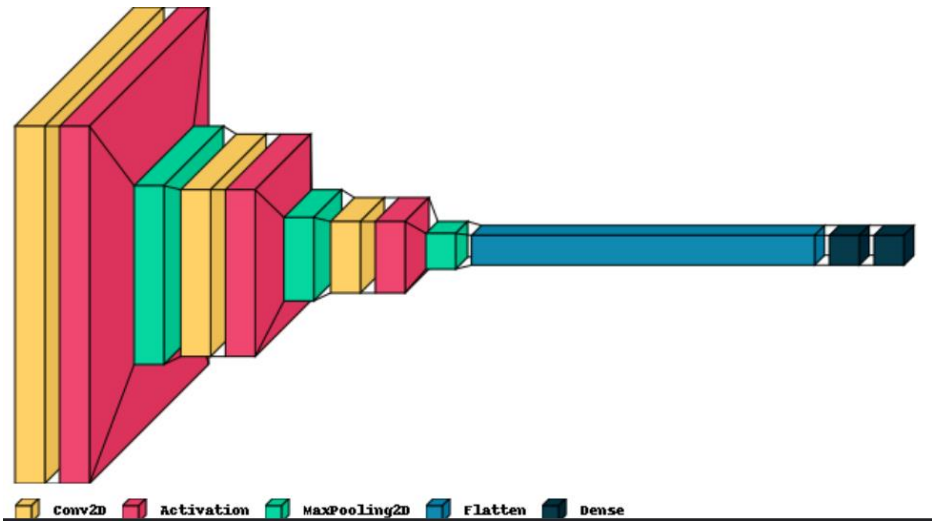

***Catatan:*** dimana output features layer pertama sejumlah dengan resolusi gambar (n)
dengan kernel 5 x 5, dan output features layer selanjutnya merupakan (
𝒏
𝟐
) dengan
kernel 3 x 3. Activation function tiap layer menggunakan ReLU.

***Declare accuracy function to accomodate the result of Accuracy value. Declare training set function to generalize training and calculate loss. Declare validation step function to generalize predictions, calculate loss, accuracy and validation value. Declare validation epoch function to calculate loss value and average accuracy value of validation after running epochs. Declare epoch end function to display training, validation loss and validation accuracy value.***

In [32]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim = 1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class Parent(nn.Module):
  
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                
        loss = Func.cross_entropy(out, labels)
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                  
        loss = Func.cross_entropy(out, labels)   
        acc = accuracy(out, labels)          
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()  
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()    
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], 
            result['val_loss'], 
            result['val_acc']))

***Create a model where there are 3 Conv2D layers where in this first layer we receive an image in the form of grescale and the output is an image with a size of 64. In the problem it can be seen that the architecture is getting smaller, therefore we divide in half so that the input received by Comv2D is so becomes 32 in the second comv2D and do the same thing in the third Comv2D, then the second is MaxPool2d which is used to do pooling on the 2d image input where the image parameter is the kernel where here we write 2.2. Then create an Activation Function using ReLU, where  a ReLu layer that changes every negative to 0. so that independent variables that have a value of 0 or more can enter the ReLU layer. Last create a Flatten function to reshaping the image that we input, after that we make the input data linear with a linear function***

In [33]:
class CNN(Parent):

  def __init__(self):
    super(CNN, self).__init__()
    self.network = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size = 5, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 32, kernel_size = 3, stride=1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 16, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Flatten(), 
            nn.Linear(784, 32),
            nn.Linear(32, 26))

  def forward(self, image): 
    return self.network(image)

***Declare get_default_device function to get default device***

In [34]:
def get_default_device():
    if torch.cuda.is_available() == True:
        return torch.device('cuda')
    else: 
        return torch.device('cpu')
device = get_default_device()
device

device(type='cpu')

***Declare to_device function to perform a data loader***

In [35]:
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
  
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl: 
            yield to_device(b, self.device)
            
    def __len__(self):
        return len(self.dl)

***Declare traindl and validdl to perform the DataLoader module to load the shared data in batch form. Delacre the batch_size variable for determining by using trial and error. It can be seen, the batchsize value is the value that we want, meaning that the data to be taken is used according to our wishes and then trained until it is finished and then returns to retrieve the data as we wished for the next sample.So that the next iteration used depends on the batch size and training data using the iterative method***

In [36]:
traindl = DataLoader(traindataset,
                     batchsize,
                     shuffle = False,
                     num_workers = 4,
                     pin_memory = True)
validdl = DataLoader(valdataset,
                     batchsize*2,
                     shuffle = False,
                     num_workers = 4,
                     pin_memory = True)

for img, label in traindl:
    print(img.size())
    break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([64, 1, 64, 64])


***Declare model variable to perform CNN function. Then declare traindl variable to perform DeviceDataLoader function in train data. Then declare validdl variable to perform DeviceDataLoader function in valid data. Last show the model from the result of data loader***

In [37]:
model = CNN()
traindl = DeviceDataLoader(traindl, device)
validdl = DeviceDataLoader(validdl, device)
to_device(model, device)

CNN(
  (network): Sequential(
    (0): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): Linear(in_features=784, out_features=32, bias=True)
    (11): Linear(in_features=32, out_features=26, bias=True)
  )
)

***Start perform training data phase and validation data phase***

In [38]:
@torch.no_grad()

def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)

    for epoch in range(epochs):
        model.train()
        train_losses = []

        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

***Show the results of val_loss to find out how much data that loss and val_acc to find out how much data that have accepted on First Model***

In [39]:
evaluate(model, validdl)

{'val_loss': 3.264542818069458, 'val_acc': 0.04645579308271408}

***Perform training on the dataset to get train_loss to find out how much training data was lost, val_loss to find out how much data was lost and val_acc to find out how much data was received on First Model***

In [40]:
history = fit(epochs, learningrate , model, traindl, validdl, opt_function)

Epoch [0], train_loss: 3.2608, val_loss: 3.2547, val_acc: 0.0488
Epoch [1], train_loss: 3.1669, val_loss: 2.7315, val_acc: 0.1269
Epoch [2], train_loss: 2.1694, val_loss: 1.7989, val_acc: 0.3738
Epoch [3], train_loss: 1.6372, val_loss: 1.4521, val_acc: 0.5048
Epoch [4], train_loss: 1.3580, val_loss: 1.2093, val_acc: 0.5794
Epoch [5], train_loss: 1.1315, val_loss: 0.9648, val_acc: 0.6561
Epoch [6], train_loss: 0.8914, val_loss: 0.7000, val_acc: 0.7554
Epoch [7], train_loss: 0.7003, val_loss: 0.5395, val_acc: 0.8101
Epoch [8], train_loss: 0.5517, val_loss: 0.4897, val_acc: 0.8244
Epoch [9], train_loss: 0.4493, val_loss: 0.4027, val_acc: 0.8629
Epoch [10], train_loss: 0.3673, val_loss: 0.3105, val_acc: 0.8960
Epoch [11], train_loss: 0.3132, val_loss: 0.2931, val_acc: 0.9074
Epoch [12], train_loss: 0.2630, val_loss: 0.2884, val_acc: 0.9061
Epoch [13], train_loss: 0.2273, val_loss: 0.2239, val_acc: 0.9286
Epoch [14], train_loss: 0.1962, val_loss: 0.1938, val_acc: 0.9357
Epoch [15], train_lo

d. Tuning arsitektur pada nomor 2c dengan menggunakan dropout, batch normalization dan lain-lainnya dan lakukan proses tuning hyperparameter. Berikan alasan mengapa arsitektur dan metode tuning hyperparameter kalian lebih baik.

***Set the model in which the BatchNorm2d layer is added and perform dataset training***

In [41]:
class NewModel(Parent):

    def __init__(self):
        super(NewModel, self).__init__()
        self.network = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size = 5, padding = 1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 32, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 16, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(2, 2),

            nn.Flatten(),
            nn.Linear(784, 32),
            nn.Linear(32, 26))
        
    def forward(self, xb):
        return self.network(xb)

***Declare learningrate variable with a value of 0.01. Then declare and opt_function2 variable to determining the Optimizer function for optimize the data using Adam Optimizer function from Torch libray because it combines the best properties of the AdaGrad and RMSProp algorithms. Declare model variable to perform CNN function. Last show the model from the result of data loader***

In [42]:
learningrate2 = 0.001
optfunction2 = torch.optim.Adam
model2 = NewModel()
to_device(model2, device)

NewModel(
  (network): Sequential(
    (0): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Flatten(start_dim=1, end_dim=-1)
    (13): Linear(in_features=784, out_features=32, bias=True)
    (14): Linear(in_features=32, out_features=26, bias=True)
  )
)

***Show the results of val_loss to find out how much data that loss and val_acc to find out how much data that have accepted on Second Model***

In [43]:
evaluate(model2, validdl)

{'val_loss': 3.264925956726074, 'val_acc': 0.035975608974695206}

***Perform training on the dataset to get train_loss to find out how much training data was lost, val_loss to find out how much data was lost and val_acc to find out how much data was received on Second Model***

In [44]:
history2 = fit(epochs, learningrate2, model2, traindl, validdl, optfunction2)

Epoch [0], train_loss: 0.6427, val_loss: 0.0888, val_acc: 0.9802
Epoch [1], train_loss: 0.0520, val_loss: 0.0199, val_acc: 0.9970
Epoch [2], train_loss: 0.0160, val_loss: 0.0103, val_acc: 0.9987
Epoch [3], train_loss: 0.0137, val_loss: 0.0062, val_acc: 0.9983
Epoch [4], train_loss: 0.0229, val_loss: 0.0047, val_acc: 0.9992
Epoch [5], train_loss: 0.0024, val_loss: 0.0021, val_acc: 0.9998
Epoch [6], train_loss: 0.0008, val_loss: 0.0005, val_acc: 1.0000
Epoch [7], train_loss: 0.0004, val_loss: 0.0007, val_acc: 0.9996
Epoch [8], train_loss: 0.0002, val_loss: 0.0003, val_acc: 1.0000
Epoch [9], train_loss: 0.0002, val_loss: 0.0003, val_acc: 1.0000
Epoch [10], train_loss: 0.0721, val_loss: 0.0882, val_acc: 0.9696
Epoch [11], train_loss: 0.0139, val_loss: 0.0151, val_acc: 0.9966
Epoch [12], train_loss: 0.0035, val_loss: 0.0026, val_acc: 0.9998
Epoch [13], train_loss: 0.0005, val_loss: 0.0007, val_acc: 0.9998
Epoch [14], train_loss: 0.0003, val_loss: 0.0003, val_acc: 1.0000
Epoch [15], train_lo

***Perform a transformation image which turn the original images in the dataset into a grayscale images so that the image has only gray, black, and white colors. Then, resize the images according to the provisions of the problem that 64X64 with the Resize function from the transform library o that the image is easier to process. Then, give the random images in dataset a probability using RandomHorizontalFlip function from transforms library. Then perform images conversion by converting images into tensor form so the images can be read by the Torch function from PyTorch. Last, perform normalize the images with a size of 0.5 X 0.5 using Normalize function from transforms library***

In [45]:
testtransforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize(64),
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5))])

e. Analisis performa dari arsitektur nomor 2d dan jelaskan hasil yang kalian 
dapatkan. Gunakan testing set yang diberikan untuk memprediksi nilai ground truth dengan predicted result.

***Import the dataset using the Imagefolder function from datasets library from PyTorch***

In [58]:
testdatasets = datasets.ImageFolder(
    root='/content/drive/MyDrive/ColabNotebook/ALS/asl_alphabet_test', transform = testtransforms)

***Declare traindl and validdl to run the DataLoader module to load shared data in batches. Delacre the batch_size variable to determine by trial and error. It can be seen, the batchsize value is 64 times 2, meaning that the data to be taken is the first 128 samples that will be trained to completion and then return to retrieve 128 data for the next sample. So that the next iteration used depends on the batch size and training data using the iterative method***

In [59]:
testloader = DataLoader(testdatasets, batchsize*2, shuffle=False, num_workers=0)
testloader = DeviceDataLoader(testloader, device)

***Calling back the classes variable***

In [60]:
classes = ['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T',
          'U','V','W','X','Y','Z']

***Calling back the groundtruth variable***

In [61]:
groundtruth = ['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T',
          'U','V','W','X','Y','Z', 'Nothing', 'Space']

***Show the result of Predicted Class using classes variable***

In [62]:
print('Predicted Class : ', classes)

Predicted Class :  ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


***Show the result of Ground Truth using groundtruth variable***

In [63]:
print('Ground Truth : ', groundtruth)

Ground Truth :  ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'Nothing', 'Space']


***Declare dataiter to perform iterating on the testloader then declare gambar and label variables to perform next to the dataiter containing the iter(testloader)***

In [64]:
dataiter = iter(testloader)
gambar, label = next(dataiter)

***Declare outputs to entering image variables in function Frist Model and predicting labels with max function from Torch library***

In [65]:
outputs = model(gambar)
_, predicted = torch.max(outputs, 1)

***Declare outputs to entering image variables in function Second Model and predicting labels with max function from Torch library***

In [66]:
outputs = model2(gambar)
_, predicted1 = torch.max(outputs, 1)

***Show the result of Prediciton from First Model using looping method***

In [67]:
for i in range (28) :
    print("Prediction Model 1: ", classes[predicted1[i]])

Prediction Model 1:  S
Prediction Model 1:  B
Prediction Model 1:  C
Prediction Model 1:  D
Prediction Model 1:  E
Prediction Model 1:  F
Prediction Model 1:  G
Prediction Model 1:  H
Prediction Model 1:  I
Prediction Model 1:  J
Prediction Model 1:  K
Prediction Model 1:  L
Prediction Model 1:  M
Prediction Model 1:  N
Prediction Model 1:  O
Prediction Model 1:  P
Prediction Model 1:  Q
Prediction Model 1:  R
Prediction Model 1:  S
Prediction Model 1:  T
Prediction Model 1:  U
Prediction Model 1:  V
Prediction Model 1:  W
Prediction Model 1:  X
Prediction Model 1:  Y
Prediction Model 1:  Z
Prediction Model 1:  A
Prediction Model 1:  Z


***Show the result of Prediciton from Second Model using looping method***

In [68]:
for i in range (28) :
    print("Prediction Model 2: ",classes[predicted1[i]])

Prediction Model 2:  S
Prediction Model 2:  B
Prediction Model 2:  C
Prediction Model 2:  D
Prediction Model 2:  E
Prediction Model 2:  F
Prediction Model 2:  G
Prediction Model 2:  H
Prediction Model 2:  I
Prediction Model 2:  J
Prediction Model 2:  K
Prediction Model 2:  L
Prediction Model 2:  M
Prediction Model 2:  N
Prediction Model 2:  O
Prediction Model 2:  P
Prediction Model 2:  Q
Prediction Model 2:  R
Prediction Model 2:  S
Prediction Model 2:  T
Prediction Model 2:  U
Prediction Model 2:  V
Prediction Model 2:  W
Prediction Model 2:  X
Prediction Model 2:  Y
Prediction Model 2:  Z
Prediction Model 2:  A
Prediction Model 2:  Z


***Show the result of Accuracy from First Model***

In [69]:
correct = 0

for j in range(len(groundtruth)):
    if classes[predicted[j]] == groundtruth[j]:
        correct += 1

accuracy = correct / len(groundtruth) * 100
print('Accuracy Model 1 : ' + str(accuracy) + '%')

Accuracy Model 1 : 89.28571428571429%


***Show the result of Accuracy from Second Model***

In [70]:
correct = 0

for j in range(len(groundtruth)):
    if classes[predicted1[j]] == groundtruth[j]:
        correct += 1

accuracy = correct / len(groundtruth) * 100
print('Accuracy Model 2: ' + str(accuracy) + '%')

Accuracy Model 2: 89.28571428571429%


***Conlusion***

1. There is a difference in performance between First Model and Second Model due to the addition of the BatchNorm2d layer.

2. There is a difference in the value of Accuracy between First Model and Second Model where the Accuracy value in Second Model is greater than the Accuracy value in First Model, due to the addition of the BatchNorm2d layer in predicting the Classes value to normalize between Neural Network layers.

3. Both models do not experience an Overfitting state so that the training data is successfully carried out by predicting the same Classes value, but there are different validation values.

***Reference***

https://towardsdatascience.com/epoch-vs-iterations-vs-batch-size-4dfb9c7ce9c9 

https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html

https://machinelearningmastery.com/rectified-linear-activation-function-for-deep-learning-neural-networks/

https://blog.jovian.ai/image-classification-american-sign-language-using-pytorch-7bef9d7e8a25 